In [583]:
import pandas_ta as ta
import pandas as pd
import mplfinance as mpf
import numpy as np

In [584]:
df = pd.DataFrame().ta.ticker("AAPL")

c:\Users\Arnas\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [585]:
df.to_csv('data.csv')

In [586]:
df = pd.read_csv('data.csv')
df.index = pd.DatetimeIndex(df['Date'], tz='utc')

In [587]:
def sell(date, position, current_price, fee_rate, df, print_debug_info=False):

    full_price = position * current_price
    price_after_fee = (1 - fee_rate) * full_price
    fee = fee_rate * full_price

    if print_debug_info:
        print(f'Sell {position} stock at {current_price} per stock (total: {price_after_fee}, fee: {fee})')

    df.loc[date, 'dbalance'] = full_price
    df.loc[date, 'dposition'] = -position
    df.loc[date, 'dfee'] = fee

    return (price_after_fee, 0, df)    

In [588]:
def buy(date, balance, current_price, fee_rate, df, print_debug_info=False):

    position = (1 - fee_rate) * balance / current_price
    fee = fee_rate * balance

    if print_debug_info:
        print(f'Buy {position} stock at {current_price} per stock (asset price: {balance}, fee: {fee})')

    df.loc[date, 'dbalance'] = -balance
    df.loc[date, 'dfee'] = fee
    df.loc[date, 'dposition'] = position
    
    return (0, position, df)

In [589]:
def exit_conditions_met(buy_price, current_price, stop_loss, take_profit, print_debug_info):

    if buy_price is None:
        # we have not yet bought any stock
        return False

    upper_bound = (1 + take_profit) * buy_price
    if current_price >= upper_bound:
        # went above upper bound
        if print_debug_info:
            print('[take profit]')
        return True

    lower_bound = (1 - stop_loss) * buy_price
    if current_price <= lower_bound:
        # went below lower bound
        if print_debug_info:
            print('[stop loss]')
        return True
    
    # we're still between bounds
    return False

In [590]:
def run_strategy(df, fee_rate, short_window, long_window, stop_loss, take_profit, initial_investment, start_date, stop_date, print_debug_info=False):

    # initialize moving averages
    df['sma-short'] = df['Close'].rolling(window=short_window).mean()
    df['sma-long'] = df['Close'].rolling(window=long_window).mean()

    # generate preliminary signal
    df['signal'] = 0
    df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
    df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

    # simulate trading only in the specified time frame.
    # sma calculation happens before to avoid incomplete smas
    if start_date is not None:
        df = df[df.index >= start_date]
    if stop_date is not None:
        df = df[df.index <= stop_date]

    # signal derivative - spikes only on buy/sell
    df['dsignal'] = df['signal'].diff().fillna(0)

    # sell/buy are implemented in such a way that they do a complete
    # transfer of balance to position and vice-versa, so leading sells
    # would mess up the profit function calculations and everything
    # would go to 0. So we need to remove any leading sell signals.
    first_buy_signal_date = df[df['dsignal'] > 0].index[0]
    df.loc[df.index < first_buy_signal_date, 'dsignal'] = 0

    # initialize balance, fee, position derivatives
    df['dbalance'] = 0.0
    df['dfee'] = 0.0
    df['dposition'] = 0.0
    
    # balance and position
    balance = initial_investment
    position = 0

    if print_debug_info:
        print(f'[pos: {position}, bal: {balance}]')

    # use buy-in price as a refernce to stop loss or take profit.
    buy_price = None
    current_price = None

    for date in df.index:

        current_price = df.loc[date, 'Close']
    
        if position > 0 and exit_conditions_met(buy_price, current_price, stop_loss, take_profit, print_debug_info):
            # remove all further generated signals and stop trading
            df.loc[df.index > date, 'dsignal'] = 0
            balance, position, df = sell(date, position, current_price, fee_rate, df, print_debug_info)
            if print_debug_info:
                print(f'[pos: {position}, bal: {balance}]')
            break

        sig = df.loc[date, 'dsignal']

        if sig == 0:
            # nothing to do
            continue

        if print_debug_info:
            print(f'date: {date}')

        if sig > 0:
            buy_price = current_price
            balance, position, df = buy(date, balance, current_price, fee_rate, df, print_debug_info)
        
        if sig < 0:
            balance, position, df = sell(date, position, current_price, fee_rate, df, print_debug_info)

        if print_debug_info:
            print(f'[pos: {position}, bal: {balance}]')

    if print_debug_info:
        print(f'profit: {balance + position * current_price - initial_investment}')

    df['position'] = df['dposition'].cumsum()

    # rate of change of closing price 
    df['dclose'] = df['Close'].diff().fillna(0)

    # rate of change of profit (shift position by 1 to account for delay)
    df['dprofit'] = df['dclose'] * df['position'].shift(1).fillna(0) - df['dfee']
    df['profit'] = df['dprofit'].cumsum()
   
    return df

In [591]:
def sharpe_ratio(profit, risk_free_rate = 0):
    return (np.mean(profit  - risk_free_rate)) / np.std(profit)

In [592]:
fee_rate = 0.02
initial_investment = 1000
start_date, end_date = '2021-01-01', '2021-12-01'

stop_loss_range = np.arange(0.1, 0.9, 0.1)
take_profit_range = np.arange(0.1, 0.9, 0.1)
short_window_range = np.arange(10, 20, 2)
long_window_range = np.arange(20, 50, 10)

# find optimal parameters with the best sharpe ratio

max_sharpe_ratio = 0
best_params = (stop_loss_range[0], take_profit_range[0], short_window_range[0], long_window_range[0]) 

for stop_loss in stop_loss_range:
    for take_profit in take_profit_range:
        for short_window in short_window_range:
            for long_window in long_window_range:

                # clear data
                df = pd.read_csv('data.csv')
                df.index = pd.DatetimeIndex(df['Date'], tz='utc')

                print(f'params: {stop_loss}, {take_profit}, {short_window}, {long_window}')
                df = run_strategy(df, fee_rate, short_window, long_window, stop_loss, take_profit, initial_investment, start_date, end_date)
                sr = sharpe_ratio(df['profit'])
                if sr > max_sharpe_ratio:
                    max_sharpe_ratio = sr
                    best_params = (stop_loss, take_profit, short_window, long_window)

df = pd.read_csv('data.csv')
df.index = pd.DatetimeIndex(df['Date'], tz='utc')

df = run_strategy(df, fee_rate, best_params[2], best_params[3], best_params[0], best_params[1], initial_investment, start_date, end_date, True)

print(f'Best sharpe ratio: {max_sharpe_ratio}')
print(f'Best params:')
print(f'Stop loss: {best_params[0]}')
print(f'Take profit: {best_params[1]}')
print(f'Short window: {best_params[2]}')
print(f'Long window: {best_params[3]}')

params: 0.1, 0.1, 10, 20
params: 0.1, 0.1, 10, 30
params: 0.1, 0.1, 10, 40
params: 0.1, 0.1, 12, 20
params: 0.1, 0.1, 12, 30
params: 0.1, 0.1, 12, 40
params: 0.1, 0.1, 14, 20
params: 0.1, 0.1, 14, 30
params: 0.1, 0.1, 14, 40
params: 0.1, 0.1, 16, 20
params: 0.1, 0.1, 16, 30
params: 0.1, 0.1, 16, 40
params: 0.1, 0.1, 18, 20
params: 0.1, 0.1, 18, 30
params: 0.1, 0.1, 18, 40
params: 0.1, 0.2, 10, 20
params: 0.1, 0.2, 10, 30
params: 0.1, 0.2, 10, 40
params: 0.1, 0.2, 12, 20
params: 0.1, 0.2, 12, 30
params: 0.1, 0.2, 12, 40
params: 0.1, 0.2, 14, 20
params: 0.1, 0.2, 14, 30
params: 0.1, 0.2, 14, 40
params: 0.1, 0.2, 16, 20
params: 0.1, 0.2, 16, 30
params: 0.1, 0.2, 16, 40
params: 0.1, 0.2, 18, 20
params: 0.1, 0.2, 18, 30
params: 0.1, 0.2, 18, 40
params: 0.1, 0.30000000000000004, 10, 20
params: 0.1, 0.30000000000000004, 10, 30
params: 0.1, 0.30000000000000004, 10, 40
params: 0.1, 0.30000000000000004, 12, 20
params: 0.1, 0.30000000000000004, 12, 30
params: 0.1, 0.30000000000000004, 12, 40
para

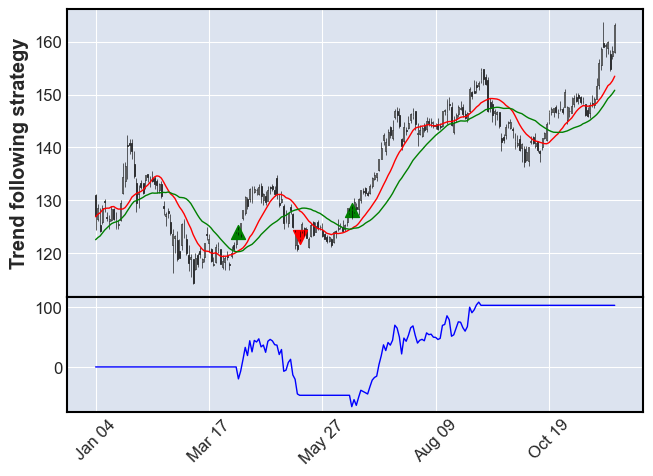

In [593]:
# Initialize sell/buy markers
df['buy_action'] = None
df.loc[df['dsignal'] > 0, 'buy_action'] = df['Close']
df['sell_action'] = None
df.loc[df['dsignal'] < 0, 'sell_action'] = df['Close']

apds = [
    mpf.make_addplot(df['buy_action'], type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green', width=1),
    mpf.make_addplot(df['sell_action'], type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red', width=1),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False, ylabel='long', width=1),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False, ylabel='short', width=1),
    mpf.make_addplot(df['profit'], panel=1, color='b', secondary_y=False, width=1),
]

mpf.plot(df, type='candle', addplot=apds, volume=False, ylabel='Trend following strategy')